<a href="https://colab.research.google.com/github/SahilDeshkar/blank-app/blob/main/credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install streamlit
!pip install pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 83.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.0.0
    Uninstalling tenacity-9.0.0:
      Successfully uninstalled tenacity-9.0.0


2024-08-06 18:02:28.338 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2024-08-06 18:02:28.339 
`st.cache` is deprecated and will be removed soon. Please use one of Streamlit's new caching commands, `st.cache_data` or `st.cache_resource`.
More information [in our docs](https://docs.streamlit.io/develop/concepts/architecture/caching).

**Note**: The behavior of `st.cache` was updated in Streamlit 1.36 to the new caching logic used by `st.cache_data` and `st.cache_resource`.
This might lead to some problems or unexpected behavior in certain edge cases.

2024-08-06 18:02:28.343 No runtime found, using MemoryCacheStorageManager
2024-08-06 18:02:28.348 No runtime found, using MemoryCacheStorageManager


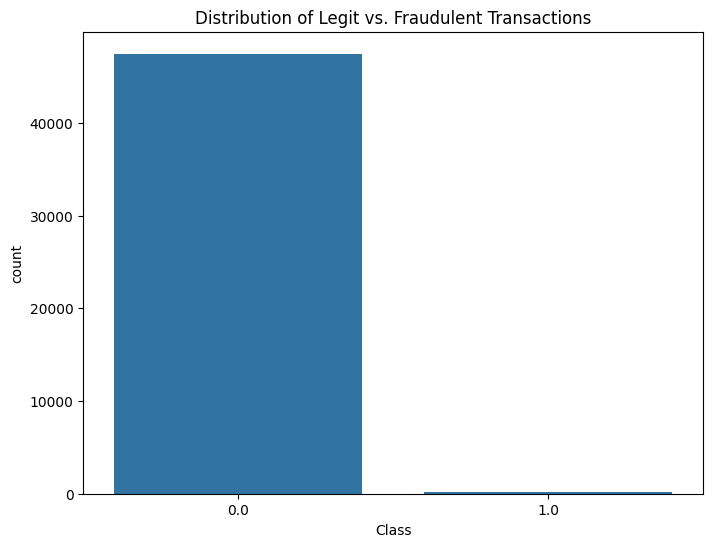

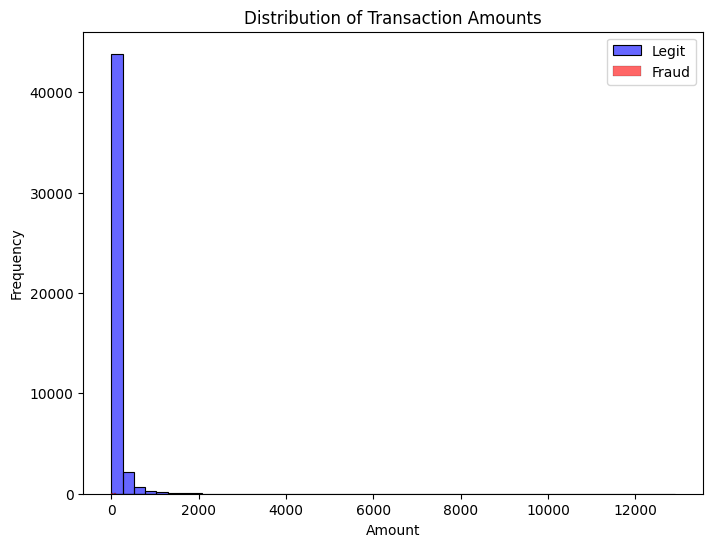

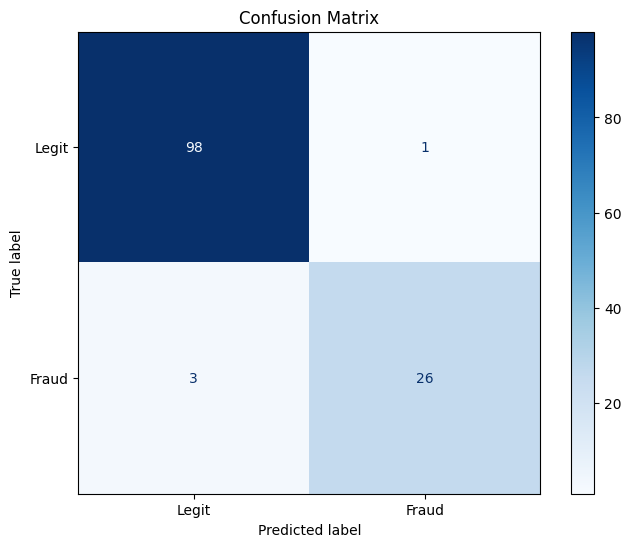

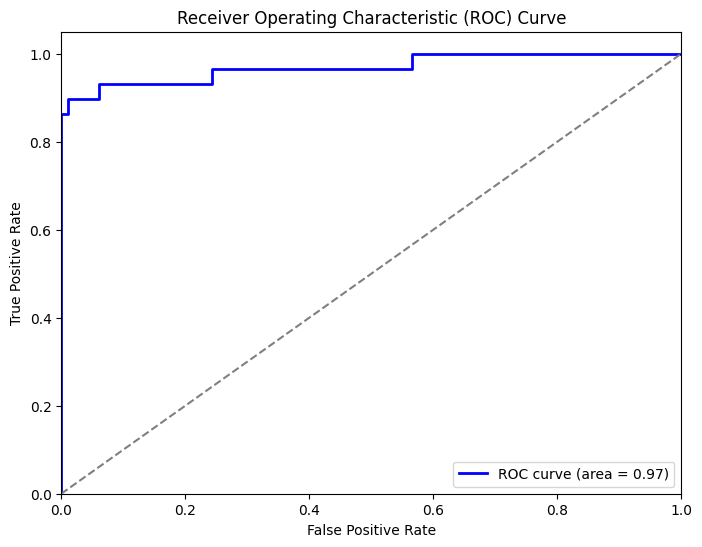

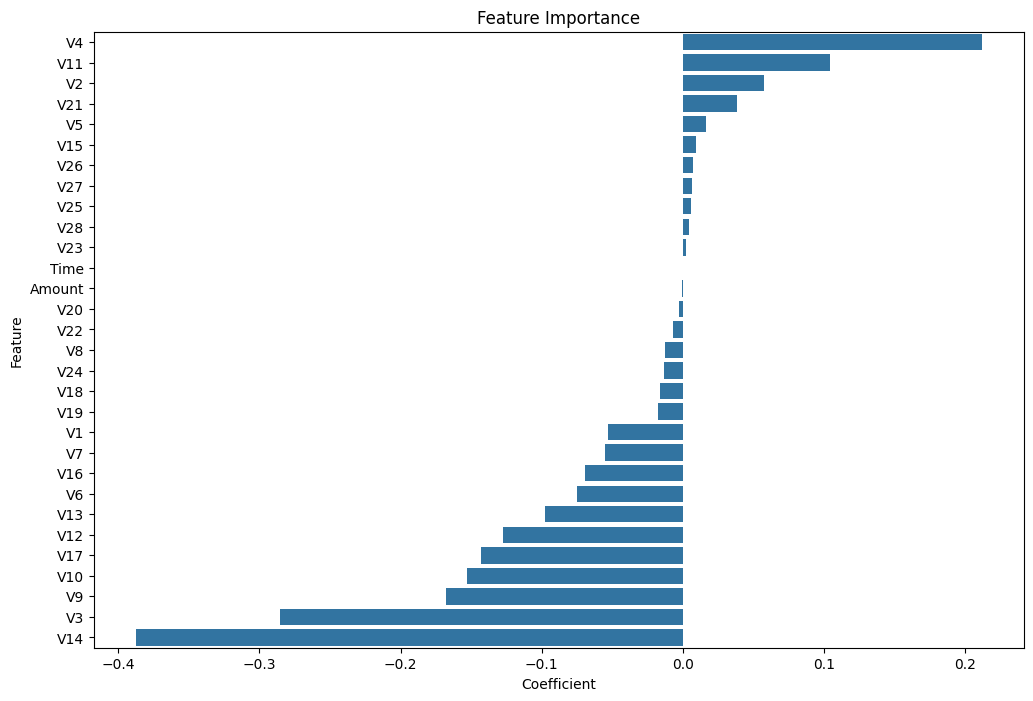

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, classification_report
import pickle
import streamlit as st

# Load the dataset
@st.cache
def load_data():
    data = pd.read_csv('/content/creditcard.csv')
    return data

data = load_data()

# Title and description
st.title('Credit Card Fraud Detection')
st.write("This application demonstrates a machine learning model for detecting credit card fraud.")

# Data overview
if st.checkbox('Show Data Overview'):
    st.write("**Dataset Information:**")
    st.write(data.info())
    st.write("**Class Distribution:**")
    st.write(data['Class'].value_counts())

# Sample and visualize data
def plot_data_distribution(data):
    st.write("**Distribution of Transactions Before Sampling:**")
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.countplot(x='Class', data=data, ax=ax)
    ax.set_title('Distribution of Legit vs. Fraudulent Transactions')
    st.pyplot(fig)

    st.write("**Distribution of Transaction Amounts:**")
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.histplot(data=data[data['Class'] == 0], x='Amount', bins=50, color='blue', label='Legit', alpha=0.6, ax=ax)
    sns.histplot(data=data[data['Class'] == 1], x='Amount', bins=50, color='red', label='Fraud', alpha=0.6, ax=ax)
    ax.set_title('Distribution of Transaction Amounts')
    ax.set_xlabel('Amount')
    ax.set_ylabel('Frequency')
    ax.legend()
    st.pyplot(fig)

plot_data_distribution(data)

# Sample the data
def sample_data(data, sample_size=492):
    legit = data[data.Class == 0]
    fraud = data[data.Class == 1]
    legit_sample = legit.sample(min(sample_size, legit.shape[0]), replace=False)
    fraud_sample = fraud.sample(min(sample_size, fraud.shape[0]), replace=False)
    return pd.concat([legit_sample, fraud_sample], axis=0)

new_data = sample_data(data)

# Prepare the feature and target variables
X = new_data.drop(columns='Class', axis=1)
Y = new_data['Class']

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

# Train the model
model = LogisticRegression(solver='liblinear')
model.fit(X_train, Y_train)

# Predictions and evaluations
X_test_prediction = model.predict(X_test)
test_accuracy = accuracy_score(Y_test, X_test_prediction)
roc_auc = roc_auc_score(Y_test, model.predict_proba(X_test)[:, 1])

# Show metrics
st.write(f"**Test Accuracy:** {test_accuracy:.2f}")
st.write(f"**ROC AUC Score:** {roc_auc:.2f}")

# Confusion Matrix
def plot_confusion_matrix(Y_test, X_test_prediction):
    cm = confusion_matrix(Y_test, X_test_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Legit', 'Fraud'])
    fig, ax = plt.subplots(figsize=(8, 6))
    disp.plot(cmap='Blues', values_format='d', ax=ax)
    ax.set_title('Confusion Matrix')
    st.pyplot(fig)

plot_confusion_matrix(Y_test, X_test_prediction)

# ROC Curve
def plot_roc_curve():
    fpr, tpr, _ = roc_curve(Y_test, model.predict_proba(X_test)[:, 1])
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='gray', linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax.legend(loc='lower right')
    st.pyplot(fig)

plot_roc_curve()

# Feature Importance
def plot_feature_importance():
    importance = model.coef_[0]
    features = X.columns
    feature_importance = pd.DataFrame({'Feature': features, 'Coefficient': importance})
    feature_importance = feature_importance.sort_values(by='Coefficient', ascending=False)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x='Coefficient', y='Feature', data=feature_importance, ax=ax)
    ax.set_title('Feature Importance')
    st.pyplot(fig)

plot_feature_importance()

# Save and load model
def save_model(model):
    with open('/content/ML_project.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model():
    with open('/content/ML_project.pkl', 'rb') as file:
        return pickle.load(file)

save_model(model)
model_loaded = load_model()

# Predictions with loaded model
st.write("**Predictions with Loaded Model on Training Data:**")
st.write(model_loaded.predict(X_train))
